Target:

    1. Add Learning rate scheduler
    2. Reach target accuracy of 99.4%

Strategy:

    1. Add ReduceLROnPlateau to decrease the learning rate during the training process

Result:

    Best train accuracy: 98.37%
    Best test accuracy: 99.43%
    Parameters: 8012

Analysis:

    1. 99.4% reaced at 12th epoch and consistent later on



# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), center = None, fill = None, expand = False),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.train_data
#train_data = train.transform(train_data.numpy())

#print('[Train]')
#print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
#print(' - Tensor Shape:', train.train_data.size())
#print(' - min:', torch.min(train_data))
#print(' - max:', torch.max(train_data))
#print(' - mean:', torch.mean(train_data))
#print(' - std:', torch.std(train_data))
#print(' - var:', torch.var(train_data))

#dataiter = iter(train_loader)
#images, labels = dataiter.next()

##print(images.shape)
#print(labels.shape)

# Let's visualize some of the images
#%matplotlib inline
import matplotlib.pyplot as plt

#plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [7]:
figure = plt.figure()
#num_of_images = 60
#for index in range(1, num_of_images + 1):
#    plt.subplot(6, 10, index)
#    plt.axis('off')
#    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

<Figure size 432x288 with 0 Axes>

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [8]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 6, 3, padding=1, bias = False),     # In -  28x28x1, Out -  28x28x6, RF - 3x3
                                   nn.ReLU(),
                                   nn.BatchNorm2d(6),
                                   nn.Conv2d(6, 12, 3, padding = 1, bias = False),  # In -  28x28x6, Out -  28x28x12, RF - 5x5
                                   nn.ReLU(),) 
        
        self.transition1 = nn.Sequential(nn.MaxPool2d(2,2),)                        # In -  28x28x12, Out -  14x14x12, RF - 6x6

        self.conv2 = nn.Sequential(nn.Dropout2d(0.15),
                                   nn.BatchNorm2d(12),
                                   nn.Conv2d(12, 16, 3, padding = 1, bias = False), # In -  14x14x12, Out -  14x14x16, RF - 10x10
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16),
                                   nn.Conv2d(16, 16, 3, padding = 1, bias = False), # In -  14x14x16, Out -  14x14x16, RF - 14x14
                                   nn.ReLU(),)
        
        self.transition2 = nn.Sequential(nn.MaxPool2d(2,2),)                        # In -  14x14x16, Out -  7x7x16, RF - 16x16

        self.conv3 = nn.Sequential(nn.Dropout2d(0.2),
                                   nn.BatchNorm2d(16),
                                   nn.Conv2d(16, 16, 3, padding=1, bias = False),   # In -  7x7x16, Out -  7x7x16, RF - 24x24
                                     nn.ReLU(),)
        
        self.final_layers = nn.Sequential(nn.AvgPool2d(7, 7),
                                          nn.BatchNorm2d(16),
                                          nn.Conv2d(16, 32, 1, bias=False),         # In -  7x7x16, Out -  1x1x16, RF - 48x48
                                          nn.ReLU(),
                                          nn.Conv2d(32, 10, 1),
                                          nn.Flatten(),
                                          nn.LogSoftmax())


    def forward(self, x):
        x = self.conv1(x)
        x = self.transition1(x)
        x = self.conv2(x)
        x = self.transition2(x)
        x = self.conv3(x)
        x = self.final_layers(x)
        return x

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              54
              ReLU-2            [-1, 6, 28, 28]               0
       BatchNorm2d-3            [-1, 6, 28, 28]              12
            Conv2d-4           [-1, 12, 28, 28]             648
              ReLU-5           [-1, 12, 28, 28]               0
         MaxPool2d-6           [-1, 12, 14, 14]               0
         Dropout2d-7           [-1, 12, 14, 14]               0
       BatchNorm2d-8           [-1, 12, 14, 14]              24
            Conv2d-9           [-1, 16, 14, 14]           1,728
             ReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
           Conv2d-12           [-1, 16, 14, 14]           2,304
             ReLU-13           [-1, 16, 14, 14]               0
        MaxPool2d-14             [

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

# Let's Train and test our model

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

#model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.4, verbose=True)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    scheduler.step(test_loss)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=0.08609221130609512 Batch_id=468 Accuracy=93.26: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0894, Accuracy: 9748/10000 (97.48%)

EPOCH: 1


Loss=0.06759509444236755 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9800/10000 (98.00%)

EPOCH: 2


Loss=0.07169250398874283 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.012102323584258556 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.034077513962984085 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.15149007737636566 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.12554767727851868 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.002392643131315708 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.01022521685808897 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9903/10000 (99.03%)

Epoch     9: reducing learning rate of group 0 to 4.0000e-03.
EPOCH: 9


Loss=0.03242676332592964 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.01519568357616663 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.003620664356276393 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.01772947423160076 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.01395802665501833 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.02203814499080181 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]



Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

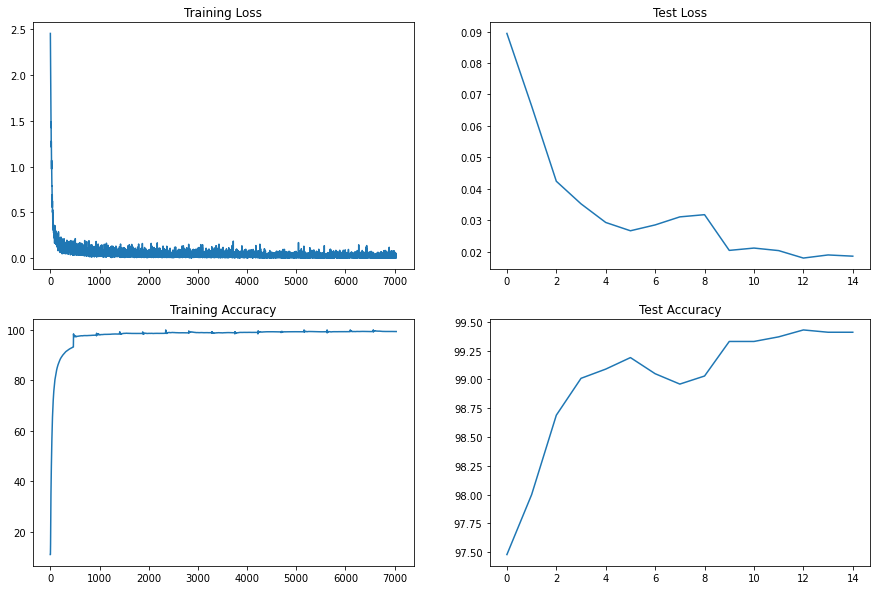

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")